In [1]:
import os
from os.path import join
import random
import shutil
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print(f"TensorFlow: {tf.__version__}")

TensorFlow: 2.2.0


# Prepare Pedestrian Dataset

In [2]:
!which python

/gpfs/space/software/jupyterhub/python/jupyter/bin/python


In [3]:
ls ../data

pedestrian_new/  steering_night/  stop_sign_dataset/
steering/        stop_sign/       zebra_dataset/


In [4]:
ls ../data/pedestrian_new

with/  without/


In [5]:
ls ../data/pedestrian_new/with | wc -l

10192


In [6]:
ls ../data/pedestrian_new/without | wc -l

10108


In [7]:
ls ../data/zebra_dataset/

with/  without/


In [8]:
ls ../data/zebra_dataset/with | wc -l

2693


In [9]:
ls ../data/zebra_dataset/without | wc -l

2647


In [10]:
data_path = "../data"
data_path_zebra = os.path.join(data_path, "zebra_dataset")
data_path_steering = os.path.join(data_path, "steering")
data_path_pedestrian = os.path.join(data_path, "pedestrian_new")

In [11]:
label_with = 1
label_without = 0

In [12]:
ls {data_path_steering}

tub_3_22-10-25/  tub_5_22-10-27/  tub_7_22-11-01/
tub_4_22-10-25/  tub_6_22-11-01/  tub_8_22-11-03/


In [13]:
steering_images = []
for thing in os.listdir(data_path_steering):
    if thing.startswith("tub") and not thing.startswith("tub_3"):
        tub_path = join(data_path_steering, thing, "images")
        for img in os.listdir(tub_path):
            steering_images.append(join(tub_path, img))

In [14]:
len(steering_images)

62463

In [15]:
steering_images[:10]

['../data/steering/tub_4_22-10-25/images/4790_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/2488_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/14077_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/7364_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/317_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/13208_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/1844_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/11363_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/13379_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/253_cam_image_array_.jpg']

In [16]:
random.seed(2022)
images = random.sample(steering_images, k=5000)

In [17]:
images[:10]

['../data/steering/tub_6_22-11-01/images/10981_cam_image_array_.jpg',
 '../data/steering/tub_7_22-11-01/images/3353_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/3091_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/7588_cam_image_array_.jpg',
 '../data/steering/tub_7_22-11-01/images/3245_cam_image_array_.jpg',
 '../data/steering/tub_5_22-10-27/images/5239_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/1665_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/3406_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/12972_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/12471_cam_image_array_.jpg']

In [18]:
labels = [0]*len(images)

In [19]:
for dataset_path in [data_path_zebra, data_path_pedestrian]:
    for img in os.listdir(join(dataset_path, "with")):
        images.append(join(dataset_path, "with", img))
        labels.append(1)
    for img in os.listdir(join(dataset_path, "without")):
        images.append(join(dataset_path, "without", img))
        labels.append(0)

In [20]:
corrupt_images = []
for i, img in enumerate(images):
    if cv2.imread(img) is None:
        corrupt_images.append(img)
        print(images[i])
        print(images.pop(i))
        print(labels.pop(i))
        print()

In [21]:
len(corrupt_images)

0

# Prepare Data Pipeline

In [22]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, shuffle=True, random_state=2022)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=2022)

In [23]:
mean = [0.4251, 0.4787, 0.4311]  # calculated in the separate notebook
std = [0.2203, 0.2276, 0.2366]  # calculated in the separate notebook


def apply_normalization(cv_image_rgb_uint8):
    image = np.float32(cv_image_rgb_uint8) / 255.0
    image -= mean
    image /= std
    return image


def reverse_normalization(cv_image_rgb_float32):
    image = cv_image_rgb_float32 * std
    image += mean
    image *= 255
    image = image.astype(np.uint8)
    return image

In [24]:
def transforms(cv_image_rgb):
    cv_image_rgb = cv_image_rgb[50:, ...] # cropping x
    return apply_normalization(cv_image_rgb)


def load_image(image_path):
    image_bgr = cv2.imread(image_path.numpy().decode("utf-8"))
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_rgb = transforms(image_rgb)
    return tf.convert_to_tensor(image_rgb)


def preprocess_labels(label):
    return tf.expand_dims(tf.cast(label, "float32"), axis=-1)


def configure_dataset(ds):
    # Keep the images in memory after they're loaded off disk during the first epoch
    ds = ds.cache()
    # Drop elements that cause errors
    ds = ds.apply(tf.data.experimental.ignore_errors())
    # Wrap the 'load_image' call inside 'tf.py_function' due to https://github.com/tensorflow/tensorflow/issues/30653
    ds = ds.map(lambda image_path, label: (
        tf.py_function(load_image, [image_path], tf.float32),
        tf.py_function(preprocess_labels, [label], np.float32)
    ), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Create batches
    ds = ds.batch(64)
    # prepare later elements while the current element is being processed
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds


ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

ds_train = configure_dataset(ds_train)
ds_val = configure_dataset(ds_val)
ds_test = configure_dataset(ds_test)

2022-12-07 10:51:44.905774: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-12-07 10:51:45.006475: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2199950000 Hz
2022-12-07 10:51:45.006960: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x655c700 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-12-07 10:51:45.007029: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-12-07 10:51:45.007665: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


2022-12-07 10:51:48.068315: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(64, 70, 160, 3)
(64, 1)


/gpfs/space/home/pyvovar/miniconda3/envs/donkey/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


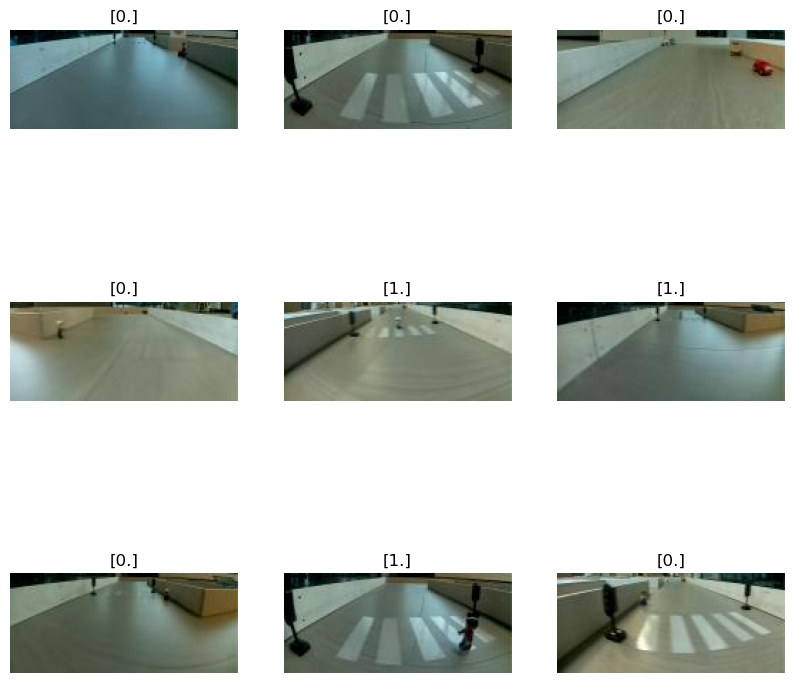

In [25]:
image_batch, label_batch = next(iter(ds_train))
print(image_batch.shape)
print(label_batch.shape)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(reverse_normalization(image_batch[-i].numpy()))
    # plt.imshow((image_batch[-i].numpy() * 255).astype(np.uint8))
    plt.title(label_batch[-i].numpy())
    plt.axis("off")

# Train the Model

In [27]:
# TODO plotting
# TODO Augmentation
# TODO add confusion matrix and choose a threshold using ROC

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(70, 160, 3)),
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

n_epochs = 5
log_frequency = 50
threshold = 0.5

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
criterion = tf.keras.losses.BinaryCrossentropy()

train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(n_epochs):
    step = 0
    # Training
    total_loss = 0.0
    total_accuracy = 0.0
    running_loss = 0.0
    running_accuracy = 0.0
    for step, (image_batch, label_batch) in enumerate(ds_train):
        with tf.GradientTape() as tape:
            logits = model(image_batch, training=True)
            loss_value = criterion(label_batch, logits)
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        # Metrics and Logging
        current_loss = loss_value.numpy()
        current_accuracy = accuracy_score(label_batch, logits > threshold)

        total_loss += current_loss
        total_accuracy += current_accuracy
        running_loss += current_loss
        running_accuracy += current_accuracy

        if (step + 1) % log_frequency == 0:
            print(
                f'Train [{epoch + 1}/{n_epochs}, {step + 1}/?]: '
                f'Loss {running_loss / log_frequency}, '
                f'Accuracy {running_accuracy / log_frequency}'
            )
            running_loss = 0.0
            running_accuracy = 0.0

    train_loss_history.append(total_loss / step)
    train_accuracy_history.append(total_accuracy / step)

    # Validation
    total_loss = 0.0
    total_accuracy = 0.0
    running_loss = 0.0
    running_accuracy = 0.0
    for step, (image_batch, label_batch) in enumerate(ds_val):
        logits = model(image_batch, training=False)
        loss_value = criterion(label_batch, logits)

        # Metrics and Logging
        current_loss = loss_value.numpy()
        current_accuracy = accuracy_score(label_batch, logits > threshold)

        total_loss += current_loss
        total_accuracy += current_accuracy

        running_loss += current_loss
        running_accuracy += current_accuracy
        if (step + 1) % log_frequency == 0:
            print(
                f'Val [{epoch + 1}/{n_epochs}, {step + 1}/?]: '
                f'Loss {running_loss / log_frequency}, '
                f'Accuracy {running_accuracy / log_frequency}'
            )
            running_loss = 0.0
            running_accuracy = 0.0

    val_loss_history.append(total_loss / step)
    val_accuracy_history.append(total_accuracy / step)

Train [1/5, 50/?]: Loss 0.6941518855094909, Accuracy 0.5746875
Train [1/5, 100/?]: Loss 0.6571606850624084, Accuracy 0.62
Train [1/5, 150/?]: Loss 0.6325522220134735, Accuracy 0.65625
Train [1/5, 200/?]: Loss 0.601484271287918, Accuracy 0.6734375
Train [1/5, 250/?]: Loss 0.5897587633132935, Accuracy 0.6784375
Train [1/5, 300/?]: Loss 0.5742295295000076, Accuracy 0.7065625
Val [1/5, 50/?]: Loss 0.5398628973960876, Accuracy 0.8309375
Train [2/5, 50/?]: Loss 0.5336599814891815, Accuracy 0.7459375
Train [2/5, 100/?]: Loss 0.5062485027313233, Accuracy 0.755
Train [2/5, 150/?]: Loss 0.49941972315311434, Accuracy 0.7534375
Train [2/5, 200/?]: Loss 0.4752850717306137, Accuracy 0.7846875
Train [2/5, 250/?]: Loss 0.4717619508504868, Accuracy 0.7834375
Train [2/5, 300/?]: Loss 0.4420399647951126, Accuracy 0.798125
Val [2/5, 50/?]: Loss 0.4075405430793762, Accuracy 0.861875
Train [3/5, 50/?]: Loss 0.4127014493942261, Accuracy 0.8109375
Train [3/5, 100/?]: Loss 0.3819392091035843, Accuracy 0.83375


# Evaluate the Model

Text(0.5, 1.0, 'Accuracy')

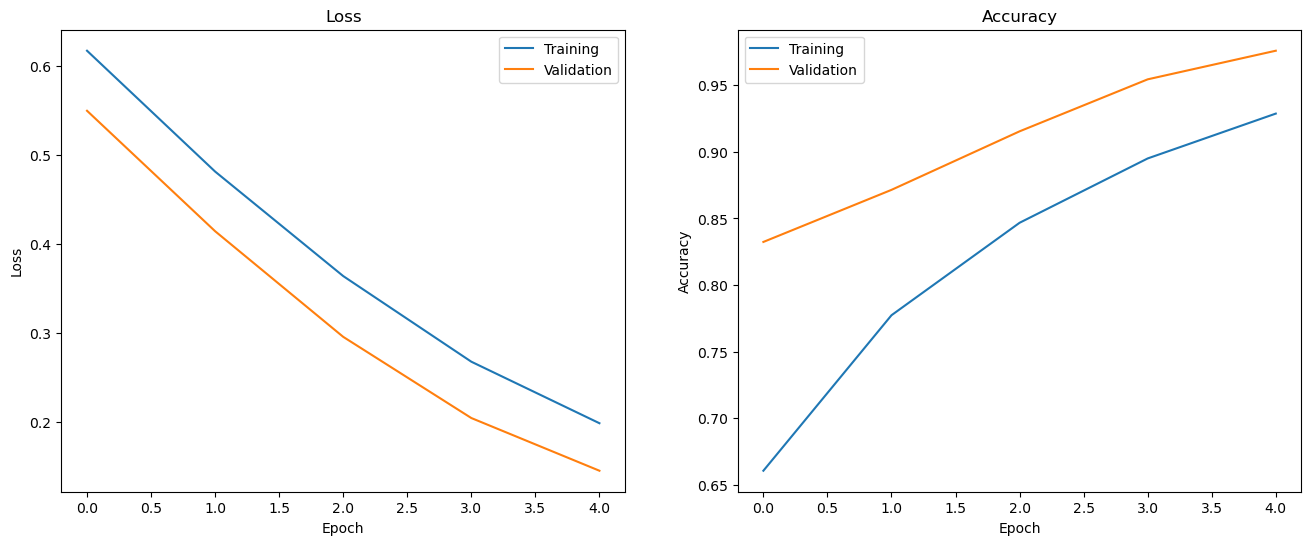

In [28]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history)
plt.plot(val_accuracy_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

In [29]:
# Evaluation
threshold = 0.5

test_loss = 0.0
test_accuracy = 0.0
batches = 0
for step, (image_batch, label_batch) in enumerate(ds_test):
    logits = model(image_batch, training=False)
    loss_value = criterion(label_batch, logits)

    # Metrics and Logging
    current_loss = loss_value.numpy()
    current_accuracy = accuracy_score(label_batch, logits > threshold)

    test_loss += current_loss
    test_accuracy += current_accuracy
    batches += 1

test_loss /= batches
test_accuracy /= batches

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.14454219257459044
Test Accuracy: 0.9641462053571428


In [30]:
model.save("pedestrian_detection_v3")

2022-12-07 11:12:04.960871: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: pedestrian_detection_v3/assets


INFO:tensorflow:Assets written to: pedestrian_detection_v3/assets
